# Vector autoregressive (VAR) processes for Granger-causality among SDGs

In a VAR model, each variable, i.e. indicator, is a linear function of the past values of itself and the past values of all the other variables. How many past values influence the current value is a hyperparameter and we set it for the subsequent example to 1. Hence, we call this a VAR(1), a vector autoregressive process of order 1. We would like to calculate the value of time step $t$ and have two variables, $y_1$ and $y_2$. 

Let $c$ be a constant, $e$ an error term, and $w_{1,11}$ the coefficient representing the influence of time step $t-1$ of variable 1 on time step $t$ of variable 1. Accordingly, $w_{1,12}$ is the coefficient representing the influence of time step $t-1$ of variable 2 on time step $t$ of variable 1.

$$
y_1(t) = c_1 + w_{1,11} \cdot y_1(t-1) + w_{1,12} \cdot y_2(t-1) + e_1(t)
$$

$$
y_2(t) = c_2 + w_{1,21} \cdot y_1(t-1) + w_{1,22} \cdot y_2(t-1) + e_2(t)
$$

As a comparison, an autoregressive process of order 1, denoted as AR(1), is only dependent on its own previous time steps.

$$
y_1(t) = c_1 + w_{1,11} \cdot y_1(t-1) + e_1(t)
$$

If we had a bivariate VAR model of order 3, we would write this as:

$$
y_1(t) = c_1 + w_{1,11} \cdot y_1(t-1) + w_{1,12} \cdot y_2(t-1) + w_{2,11} \cdot y_1(t-2) + w_{2,12} \cdot y_2(t-2) + w_{3,11} \cdot y_1(t-3) + w_{3,12} \cdot y_2(t-3) + e_1(t)
$$

$$
y_2(t) = c_2 + w_{1,21} \cdot y_1(t-1) + w_{1,22} \cdot y_2(t-1) + w_{2,21} \cdot y_1(t-2) + w_{2,22} \cdot y_2(t-2) + w_{3,21} \cdot y_1(t-3) + w_{3,22} \cdot y_2(t-3) + e_2(t)
$$

Can you already see the connection to Granger-causality? We divide our data set in traning and validation set and predict the value of, say, $y_1$ with and without additional variables. If the prediction *with* additional variables was statistically significantly more accurate, meaning closer to the values in our validation set, these additional variables would have a Granger-causal effect on $y_1$. In our equations, this Granger-causal influence is represented by non-zero weights $w$, also referred to as autoregressive (AR) coefficients. Here, we apply a statistical test, most likely the F-test, to test whether the VAR process results in more accurate predictions than the AR process.

## Exhaustive graphical Granger method

In [Arnold et al (2007)](https://www.andrewoarnold.com/frp781-arnold.pdf), the method we subsequently explain is referred to as the exhaustive graphical Granger method. Here, we see the set of variables as a complete graph $G$, i.e. we have edges between each pair of variables. 

We iterate over each edge $(y_1,y_2)$ in this complete graph $G$.
- We orient $y_1 \rightarrow y_2$ if the prediction of $y_2$ is statistically significantly more accurate with $y_1$ than without $y_1$. 
- We also test the opposite direction, i.e. we test whether the prediction of $y_1$ is statistically significantly more accurate with $y_2$ than without $y_2$. If so, we orient $y_1 \leftarrow y_2$. 
- If both scenarios hold true, we orient $y_1 \leftrightarrow y_2$. 
- If none of these two scanrios hold true, we omit any Granger-causal dependence between $y_1$ and $y_2$, i.e. we delete the edge between $y_1$ and $y_2$.

In [1]:
import numpy as np
import pandas as pd
import math
import os
import pickle
import copy
import itertools
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# loading data set
dict_all_i = pickle.load(open('utils/data/dict_all_i.pkl', 'rb'))
indicators_values = pickle.load(open('utils/data/indicators_values_i_up.pkl', 'rb'))
info = pd.read_csv('utils/info.csv', dtype=str)

In [3]:
subindicators = list(info['SeriesCode'].unique())
subindicators

['SI_POV_DAY1',
 'SI_POV_EMP1',
 'SI_POV_NAHC',
 'SI_COV_MATNL',
 'SI_COV_POOR',
 'SI_COV_SOCAST',
 'SI_COV_SOCASTPQ',
 'SI_COV_SOCINS',
 'SI_COV_CHLD',
 'SI_COV_SOCINSPQ',
 'SI_COV_UEMP',
 'SI_COV_VULN',
 'SI_COV_WKINJRY',
 'SI_COV_BENFTS',
 'SI_COV_DISAB',
 'SI_COV_LMKT',
 'SI_COV_LMKTPQ',
 'SI_COV_PENSN',
 'SP_ACS_BSRVH2O',
 'SP_ACS_BSRVSAN',
 'VC_DSR_GDPLS',
 'VC_DSR_MISS',
 'VC_DSR_AFFCT',
 'VC_DSR_MORT',
 'VC_DSR_MTMP',
 'VC_DSR_MTMN',
 'VC_DSR_DAFF',
 'VC_DSR_IJILN',
 'VC_DSR_PDAN',
 'VC_DSR_PDYN',
 'VC_DSR_PDLN',
 'SG_DSR_LGRGSR',
 'SG_DSR_SILS',
 'SG_DSR_SILN',
 'SG_GOV_LOGV',
 'VC_DSR_LSGP',
 'VC_DSR_AGLN',
 'VC_DSR_HOLN',
 'VC_DSR_CILN',
 'VC_DSR_CHLN',
 'VC_DSR_DDPA',
 'SD_XPD_ESED',
 'SN_ITK_DEFC',
 'AG_PRD_FIESSI',
 'AG_PRD_FIESSIN',
 'SN_ITK_DEFCN',
 'SH_STA_STUNT',
 'SH_STA_STUNTN',
 'SH_STA_WASTE',
 'SH_STA_WASTEN',
 'SH_STA_OVRWGT',
 'SH_STA_OVRWGTN',
 'PD_AGR_SSFP',
 'SI_AGR_SSFP',
 'ER_GRF_ANIMRCNT',
 'ER_GRF_PLNTSTOR',
 'ER_RSK_LBREDS',
 'AG_PRD_ORTIND',
 'DC_TOF_A

In [4]:
period = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [5]:
# check
dict_all_i['France'].head()

TimePeriod        1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 ...   \
SeriesCode                                                          ...    
AG_FPA_CFPI        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
AG_FPA_COMM        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
AG_LND_DGRD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
AG_LND_FRST        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
AG_LND_FRSTBIOPHA  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    

TimePeriod             2010 2011 2012 2013 2014     2015       2016  \
SeriesCode                                                            
AG_FPA_CFPI             NaN  NaN  NaN  NaN  NaN      NaN          1   
AG_FPA_COMM             NaN  NaN  NaN  NaN  NaN      NaN -0.0447798   
AG_LND_DGRD             NaN  NaN  NaN  NaN  NaN      NaN        NaN   
AG_LND_FRST        -1.43641  NaN  NaN  NaN  NaN  1.14621        NaN   
AG_LND_FRSTBIOPHA  0.318645  NaN  NaN  NaN  NaN   1.3148        NaN   

TimePeriod              2017 2018 2019  
SeriesCode                              
AG_FPA_CFPI               -1  NaN  NaN  
AG_FPA_COMM        0.0697461  NaN  NaN  
AG_LND_DGRD              NaN  NaN  NaN  
AG_LND_FRST              NaN  NaN  NaN  
AG_LND_FRSTBIOPHA        NaN  NaN  NaN  

[5 rows x 30 columns]

In [6]:
# simply transpose
dict_all_i['Germany'].T.loc['2000':'2018']

SeriesCode AG_FPA_CFPI AG_FPA_COMM AG_LND_DGRD AG_LND_FRST AG_LND_FRSTBIOPHA  \
TimePeriod                                                                     
2000               NaN         NaN         NaN   -0.985091          -1.25263   
2001               NaN         NaN         NaN         NaN               NaN   
2002               NaN         NaN         NaN         NaN               NaN   
2003               NaN         NaN         NaN         NaN               NaN   
2004               NaN         NaN         NaN         NaN               NaN   
2005               NaN         NaN         NaN   -0.867764         -0.497779   
2006               NaN         NaN         NaN         NaN               NaN   
2007               NaN         NaN         NaN         NaN               NaN   
2008               NaN         NaN         NaN         NaN               NaN   
2009               NaN         NaN         NaN         NaN               NaN   
2010               NaN         NaN         NaN    0.397256          0.304608   
2011               NaN         NaN         NaN         NaN               NaN   
2012               NaN         NaN         NaN         NaN               NaN   
2013               NaN         NaN         NaN         NaN               NaN   
2014               NaN         NaN         NaN         NaN               NaN   
2015               NaN         NaN         NaN      1.4556            1.4458   
2016                 1  -0.0514371         NaN         NaN               NaN   
2017                -1   0.0880199         NaN         NaN               NaN   
2018               NaN         NaN         NaN         NaN               NaN   

SeriesCode AG_LND_FRSTCERT AG_LND_FRSTCHG AG_LND_FRSTMGT AG_LND_FRSTN  \
TimePeriod                                                              
2000              -2.44435            NaN       0.463026     -1.49019   
2001                   NaN            NaN            NaN          NaN   
2002                   NaN            NaN            NaN          NaN   
2003                   NaN            NaN            NaN          NaN   
2004                   NaN            NaN            NaN          NaN   
2005              0.281377      -0.654371       -1.38875    -0.310278   
2006                   NaN            NaN            NaN          NaN   
2007                   NaN            NaN            NaN          NaN   
2008                   NaN            NaN            NaN          NaN   
2009                   NaN            NaN            NaN          NaN   
2010              0.374029        1.41293       0.925727     0.723835   
2011                   NaN            NaN            NaN          NaN   
2012                   NaN            NaN            NaN          NaN   
2013                   NaN            NaN            NaN          NaN   
2014                   NaN            NaN            NaN          NaN   
2015              0.423073      -0.758562            NaN      1.07663   
2016              0.402393            NaN            NaN          NaN   
2017              0.459201            NaN            NaN          NaN   
2018              0.504279            NaN            NaN          NaN   

SeriesCode AG_LND_FRSTPRCT     ...      SG_PLN_RECRIMON SG_PLN_RECNDI  \
TimePeriod                     ...                                      
2000             -0.858729     ...                  NaN           NaN   
2001                   NaN     ...                  NaN           NaN   
2002                   NaN     ...                  NaN           NaN   
2003                   NaN     ...                  NaN           NaN   
2004                   NaN     ...                  NaN           NaN   
2005              -1.41259     ...                  NaN           NaN   
2006                   NaN     ...                  NaN           NaN   
2007                   NaN     ...                  NaN           NaN   
2008                   NaN     ...                  NaN

In [7]:
subindicators_tables = {}

for country in dict_all_i.keys():
    subindicators_tables[country] = dict_all_i[country].T.loc['2000':'2018']

In [8]:
subindicators_tables['Germany']

SeriesCode AG_FPA_CFPI AG_FPA_COMM AG_LND_DGRD AG_LND_FRST AG_LND_FRSTBIOPHA  \
TimePeriod                                                                     
2000               NaN         NaN         NaN   -0.985091          -1.25263   
2001               NaN         NaN         NaN         NaN               NaN   
2002               NaN         NaN         NaN         NaN               NaN   
2003               NaN         NaN         NaN         NaN               NaN   
2004               NaN         NaN         NaN         NaN               NaN   
2005               NaN         NaN         NaN   -0.867764         -0.497779   
2006               NaN         NaN         NaN         NaN               NaN   
2007               NaN         NaN         NaN         NaN               NaN   
2008               NaN         NaN         NaN         NaN               NaN   
2009               NaN         NaN         NaN         NaN               NaN   
2010               NaN         NaN         NaN    0.397256          0.304608   
2011               NaN         NaN         NaN         NaN               NaN   
2012               NaN         NaN         NaN         NaN               NaN   
2013               NaN         NaN         NaN         NaN               NaN   
2014               NaN         NaN         NaN         NaN               NaN   
2015               NaN         NaN         NaN      1.4556            1.4458   
2016                 1  -0.0514371         NaN         NaN               NaN   
2017                -1   0.0880199         NaN         NaN               NaN   
2018               NaN         NaN         NaN         NaN               NaN   

SeriesCode AG_LND_FRSTCERT AG_LND_FRSTCHG AG_LND_FRSTMGT AG_LND_FRSTN  \
TimePeriod                                                              
2000              -2.44435            NaN       0.463026     -1.49019   
2001                   NaN            NaN            NaN          NaN   
2002                   NaN            NaN            NaN          NaN   
2003                   NaN            NaN            NaN          NaN   
2004                   NaN            NaN            NaN          NaN   
2005              0.281377      -0.654371       -1.38875    -0.310278   
2006                   NaN            NaN            NaN          NaN   
2007                   NaN            NaN            NaN          NaN   
2008                   NaN            NaN            NaN          NaN   
2009                   NaN            NaN            NaN          NaN   
2010              0.374029        1.41293       0.925727     0.723835   
2011                   NaN            NaN            NaN          NaN   
2012                   NaN            NaN            NaN          NaN   
2013                   NaN            NaN            NaN          NaN   
2014                   NaN            NaN            NaN          NaN   
2015              0.423073      -0.758562            NaN      1.07663   
2016              0.402393            NaN            NaN          NaN   
2017              0.459201            NaN            NaN          NaN   
2018              0.504279            NaN            NaN          NaN   

SeriesCode AG_LND_FRSTPRCT     ...      SG_PLN_RECRIMON SG_PLN_RECNDI  \
TimePeriod                     ...                                      
2000             -0.858729     ...                  NaN           NaN   
2001                   NaN     ...                  NaN           NaN   
2002                   NaN     ...                  NaN           NaN   
2003                   NaN     ...                  NaN           NaN   
2004                   NaN     ...                  NaN           NaN   
2005              -1.41259     ...                  NaN           NaN   
2006                   NaN     ...                  NaN           NaN   
2007                   NaN     ...                  NaN           NaN   
2008                   NaN     ...                  NaN

### Plotting non-stationary time-series

Building one large data frame with non-stationary sub-indicators from all countries:

In [9]:
global_df_nonstationary = pd.concat([subindicators_tables[country] for country in subindicators_tables.keys()], sort=True)

In [10]:
# sort
global_df_nonstationary.sort_index(inplace=True)

In [11]:
# change type to float
global_df_nonstationary = global_df_nonstationary.astype(float)

In [12]:
# check
global_df_nonstationary.head()

AG_FPA_CFPI  AG_FPA_COMM  AG_LND_DGRD  AG_LND_FRST  \
TimePeriod                                                       
2000                NaN          NaN          NaN     1.612933   
2000                NaN          NaN          NaN    -0.662333   
2000                NaN          NaN          NaN    -0.993842   
2000                NaN          NaN          NaN    -1.132901   
2000                NaN          NaN          NaN    -1.415046   

            AG_LND_FRSTBIOPHA  AG_LND_FRSTCERT  AG_LND_FRSTCHG  \
TimePeriod                                                       
2000                -1.590414        -1.513614             NaN   
2000                 1.174725        -0.524514             NaN   
2000                -0.592585        -2.291236             NaN   
2000                 0.683623        -0.826303             NaN   
2000                -0.352372        -2.435692             NaN   

            AG_LND_FRSTMGT  AG_LND_FRSTN  AG_LND_FRSTPRCT     ...       \
TimePeriod                                                    ...        
2000             -0.644840      1.367444        -0.407183     ...        
2000             -1.126001     -1.600015        -0.990561     ...        
2000             -1.407824      0.286819        -1.225921     ...        
2000             -0.546958     -0.642919         1.396866     ...        
2000             -0.843530     -1.622059        -0.961368     ...        

            VC_PRR_SEXV  VC_PRS_UNSEC  VC_SNS_WALN  VC_VAW_MARR  \
TimePeriod                                                        
2000                NaN           NaN          NaN          NaN   
2000                NaN           NaN          NaN          NaN   
2000                NaN           NaN          NaN          NaN   
2000                NaN           NaN          NaN          NaN   
2000                NaN           NaN          NaN          NaN   

            VC_VAW_MTUHRA  VC_VAW_PHYPYV  VC_VAW_SXVLN  VC_VOV_PHYL  \
TimePeriod                                                            
2000                  NaN            NaN           NaN          NaN   
2000                  NaN            NaN           NaN          NaN   
2000                  NaN            NaN           NaN          NaN   
2000                  NaN            NaN           NaN          NaN   
2000                  NaN            NaN           NaN          NaN   

            VC_VOV_ROBB  VC_VOV_SEXL  
TimePeriod                            
2000                NaN          NaN  
2000                NaN          NaN  
2000                NaN          NaN  
2000                NaN          NaN  
2000                NaN          NaN  

[5 rows x 391 columns]

In [13]:
# averaging country values in same years to plot mean function
global_df_nonstationary_mean = global_df_nonstationary.groupby(by='TimePeriod').mean()

In [14]:
# check for highest value
global_df_nonstationary_mean.max().max()

5.849719520609162

In [15]:
# check for shape
global_df_nonstationary_mean.shape

(19, 391)

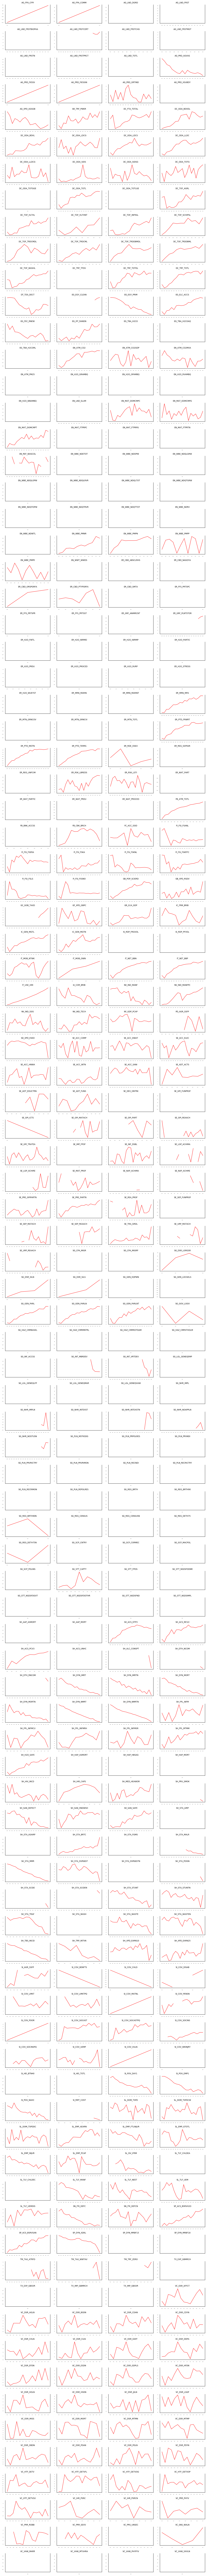

In [16]:
# plot
fig, axes = plt.subplots(nrows=97, ncols=4, dpi=120, figsize=(12,148))    # nrows must be set as smaller rounded number of subindicators / 4
for i, ax in enumerate(axes.flatten()):
    data = global_df_nonstationary_mean[global_df_nonstationary_mean.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ax.set_title(global_df_nonstationary_mean.columns[i], fontdict={'fontsize': 8})
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=2)

plt.tight_layout()
plt.savefig('utils/data/subindicator_values_nonstationary.png')

## SDG subindicator time-series made stationary

We make our time-series stationary with differencing or log-transformation.

In [17]:
# check
subindicators_tables['Germany']['AG_LND_FRST'][str(int('2002') - 1)]

nan

In [18]:
def difference(series, period, interval=1):
    diff = list()
    for i in period[1:]:
        value = np.subtract(series[i], series[str(int(i) - interval)])
        diff.append(value)
    return pd.Series(diff, index=period[1:])

In [19]:
# differencing
subindicators_tables_stationary = subindicators_tables.copy()

for country in subindicators_tables.keys():
    for subindicator in list(subindicators_tables[country].columns):
        subindicators_tables_stationary[country][subindicator] = difference(subindicators_tables[country][subindicator], period)
        subindicators_tables_stationary[country].fillna(0, inplace=True)

In [20]:
# check
subindicators_tables_stationary['Benin']

SeriesCode  AG_FPA_CFPI  AG_FPA_COMM  AG_LND_DGRD  AG_LND_FRST  \
TimePeriod                                                       
2000                0.0     0.000000          0.0     0.000000   
2001                0.0     0.000000          0.0    -1.239219   
2002                0.0     0.000000          0.0     0.000000   
2003                0.0     0.000000          0.0     0.000000   
2004                0.0     0.000000          0.0     0.000000   
2005                0.0     0.000000          0.0     0.384836   
2006                0.0     0.000000          0.0    -0.384836   
2007                0.0     0.000000          0.0     0.000000   
2008                0.0     0.000000          0.0     0.000000   
2009                0.0     0.000000          0.0     0.000000   
2010                0.0     0.000000          0.0    -0.105820   
2011                0.0     0.000000          0.0     0.105820   
2012                0.0     0.000000          0.0     0.000000   
2013                0.0     0.000000          0.0     0.000000   
2014                0.0     0.000000          0.0     0.000000   
2015                0.0     0.000000          0.0    -1.518236   
2016                0.0    -0.053973          0.0     1.518236   
2017               -2.0     0.111408          0.0     0.000000   
2018                0.0    -0.057435          0.0     0.000000   

SeriesCode  AG_LND_FRSTBIOPHA  AG_LND_FRSTCERT  AG_LND_FRSTCHG  \
TimePeriod                                                       
2000                 0.000000         0.000000        0.000000   
2001                 1.607260        -0.057846        0.000000   
2002                 0.000000         0.000000        0.000000   
2003                 0.000000         0.000000        0.000000   
2004                 0.000000         0.000000        0.000000   
2005                 0.204038         0.008081        0.672389   
2006                -0.204038        -0.008081       -0.672389   
2007                 0.000000         0.000000        0.000000   
2008                 0.000000         0.000000        0.000000   
2009                 0.000000         0.000000        0.000000   
2010                 0.259702         0.724890        0.741265   
2011                -0.259702        -0.724890       -0.741265   
2012                 0.000000         0.000000        0.000000   
2013                 0.000000         0.000000        0.000000   
2014                 0.000000         0.000000        0.000000   
2015                 1.143520         1.459660       -1.413654   
2016                -1.143520        -3.539334        1.413654   
2017                 0.000000         2.015304        0.000000   
2018                 0.000000        -0.042062        0.000000   

SeriesCode  AG_LND_FRSTMGT  AG_LND_FRSTN  AG_LND_FRSTPRCT      ...        \
TimePeriod                                                     ...         
2000              0.000000      0.000000         0.000000      ...         
2001              1.054421     -1.346512        -0.956274      ...         
2002              0.000000      0.000000         0.000000      ...         
2003              0.000000      0.000000         0.000000      ...         
2004              0.000000      0.000000         0.000000      ...         
2005             -0.288969      0.441172        -0.596303      ...         
2006              0.288969     -0.441172         0.596303      ...         
2007              0.000000      0.000000         0.000000      ...         
2008              0.000000      0.000000         0.000000      ...         
2009              0.000000      0.000000         0.000000      ...         
2010              1.343389     -0.449788        -1.334363      ...         
2011             -1.343389      0.449788         1.334363      ...         
2012              0.000000      0.000000         0.000000      ...         
2013              0.000000      0.000000         0.000000      ...         
2014      

In [21]:
# better save these precious data
st = open('utils/data/subindicators_stationary_tables.pkl', 'wb')
pickle.dump(subindicators_tables_stationary, st)
st.close()

In [22]:
# CHECKPOINT
subindicators_tables_stationary = pickle.load(open('utils/data/subindicators_stationary_tables.pkl', 'rb'))

### Plotting stationary time-series

Building one large data frame with stationary values from all countries:

*We take the stationary data frame by differencing only, not the log differencing one.*

In [23]:
global_df_stationary = pd.concat([subindicators_tables_stationary[country] for country in subindicators_tables_stationary.keys()], sort=True)

In [24]:
# sort
global_df_stationary.sort_index(inplace=True)

In [25]:
# change type to float
global_df_stationary = global_df_stationary.astype(float)

In [26]:
# averaging country values in same years to plot mean function
global_df_stationary_mean = global_df_stationary.groupby(by='TimePeriod').mean()

In [27]:
# check for highest value
global_df_stationary_mean.max().max()

6.2061336136755205

In [28]:
# check for shape
global_df_stationary_mean.shape

(19, 391)

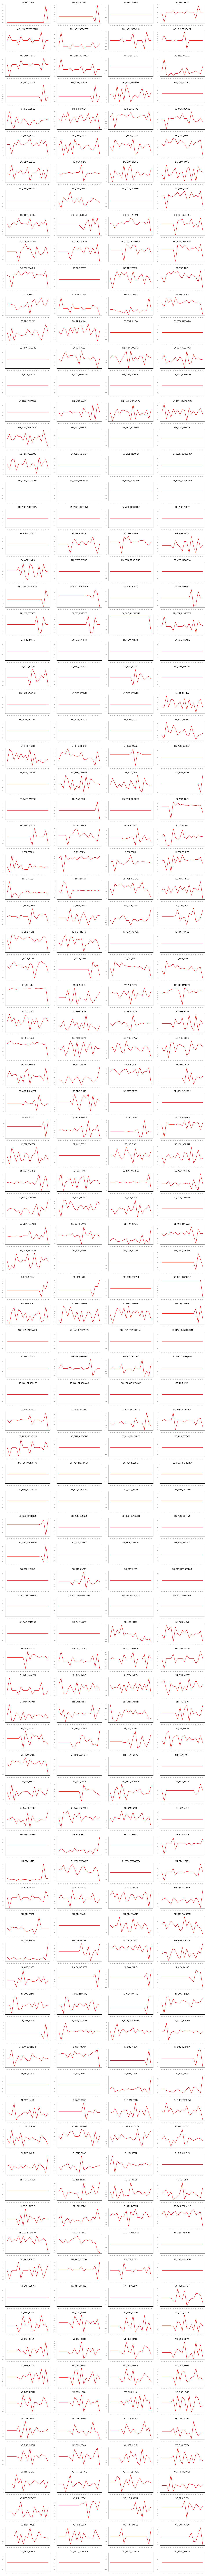

In [29]:
# plot
fig, axes = plt.subplots(nrows=97, ncols=4, dpi=120, figsize=(12,148))    # nrows must be set as smaller rounded number of subindicators / 4
for i, ax in enumerate(axes.flatten()):
    data = global_df_stationary_mean[global_df_stationary_mean.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ax.set_title(global_df_stationary_mean.columns[i], fontdict={'fontsize': 8})
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=2)

plt.tight_layout()
plt.savefig('utils/data/subindicator_values_stationary.png')

## Granger-causality test for detecting causaly dependent variables

Compute Granger Causality of all possible combinations of **indicators**. The rows are the response variable, columns are predictors. The values in the table are the p-values. P-values lesser than the significance level (0.05), implies the **null hypothesis** that the coefficients of the corresponding past values is zero, that is, the **X does not cause Y** can be rejected.

### Defining a matrix plotting Granger-causality coefficients

We define a function with the following inputs:


    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.

In [30]:
def granger_matrix(data, variables, test='ssr_chi2test', maxlag=5):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]

            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

### Data preparation

VAR models assume time-series are stationary. Hence, we use our previously prepared stationary time-series from hereon.

In [31]:
indicators = list(info['Indicator'].unique())

dict_indicators = {}

for indicator in indicators:
    i = info['SeriesCode'].where(info['Indicator'] == indicator)

    dict_indicators[indicator] = [s for s in i if str(s) != 'nan']

We start by preparing the data to have cells in data frames containing a list with entries of the sub-indicators. Each country has its own data frame:

In [32]:
indicators_tables_stationary = {}

for country in subindicators_tables_stationary.keys():
    indicators_tables_stationary[country] = pd.DataFrame(index=period, columns=indicators)
    
    for year in period:
        for indicator in indicators:
            list_subindicators_values = []
            
            for subindicator in list(dict_indicators[indicator]):
                list_subindicators_values.append(subindicators_tables_stationary[country].loc[year, subindicator])
            
            indicators_tables_stationary[country].loc[year, indicator] = list_subindicators_values

Next, we will treat the targets and goals as vectors with *m* measurements, where *m* is the number of sub-indicators belonging to each target and goal:

In [33]:
targets = list(info['Target'].unique())

dict_targets = {}

for target in targets:
    t = info['Indicator'].where(info['Target'] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [34]:
targets_tables_stationary = {}

for country in indicators_tables_stationary.keys():
    targets_tables_stationary[country] = pd.DataFrame(index=period, columns=targets)
    
    for year in period:
        for target in targets:
            list_indicators_values = []
            
            for indicator in list(dict_targets[target]):
                list_indicators_values.extend(indicators_tables_stationary[country].loc[year, indicator])
            
            targets_tables_stationary[country].loc[year, target] = list_indicators_values

In [35]:
# averaging for Granger-causality
targets_tables_stationary_mean = targets_tables_stationary.copy()

for country in targets_tables_stationary.keys():
    for target in targets_tables_stationary[country].columns:
        for year in targets_tables_stationary[country].index:
            targets_tables_stationary_mean[country].loc[year, target] = np.mean(targets_tables_stationary[country].loc[year, target])

In [36]:
goals = list(info['Goal'].unique())

dict_goals = {}

for goal in goals:
    g = info['Target'].where(info['Goal'] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']

In [37]:
goals_tables_stationary = {}

for country in targets_tables_stationary.keys():
    goals_tables_stationary[country] = pd.DataFrame(index=period, columns=goals)
    
    for year in period:
        for goal in goals:
            list_targets_values = []
            for target in list(dict_goals[goal]):
                list_targets_values.append(targets_tables_stationary[country].loc[year, target])
            
            goals_tables_stationary[country].loc[year, goal] = list_targets_values

In [38]:
# averaging for Granger-causality
goals_tables_stationary_mean = goals_tables_stationary.copy()

for country in goals_tables_stationary.keys():
    for goal in goals_tables_stationary[country].columns:
        for year in goals_tables_stationary[country].index:
            goals_tables_stationary_mean[country].loc[year, goal] = np.mean(goals_tables_stationary[country].loc[year, goal])

In [39]:
# better save these precious data
i = open('utils/data/indicators_values_stationary.pkl', 'wb')
t = open('utils/data/targets_values_stationary.pkl', 'wb')
g = open('utils/data/goals_values_stationary.pkl', 'wb')
pickle.dump(indicators_tables_stationary, i)
pickle.dump(targets_tables_stationary, t)
pickle.dump(goals_tables_stationary, g)
i.close()
t.close()
g.close()

## Granger-causality tests on target-level

In [40]:
granger_targets = {}

for country in targets_tables_stationary.keys():
    granger_targets[country] = granger_matrix(data=targets_tables_stationary_mean[country], variables=targets, maxlag=3)

As a remark for interpreting the table with its p-values between columns and rows: If a given **p-value is smaller than the significance level (0.05)**, then, the corresponding **X series (column) causes the Y (row)**.

### $VAR(n)$ models
Next, we define $VAR(n)$ models with the X variables which influence the Y variables according to the previous Granger-causality test, where $n$ is the maximum lag checked for in the Granger-causality tests. We define one $VAR(n)$ model for each Y variable, i.e. for each row in our Granger-causality matrix. Wherever the p-value of the Granger-causality test was smaller than the statistical significance level of $\alpha = 0.05$, we say that the variable X in the column Granger-caused the variable Y in the row. 

In [41]:
# check
granger_targets['France'].head()

1.1_x   1.2_x   1.3_x   1.4_x   1.5_x   1.a_x   2.1_x   2.2_x   2.3_x  \
1.1_y  1.0000  0.3782  0.0673  0.6925  0.3732  0.0667  0.0002  0.2385  0.0914   
1.2_y  0.0871  1.0000  0.0022  0.0227  0.8835  0.3967  0.5398  0.1180  0.1699   
1.3_y  0.4225  0.0002  1.0000  0.5173  0.0988  0.0399  0.0891  0.1508  0.0338   
1.4_y  0.5626  0.7977  0.3075  1.0000  0.0000  0.0439  0.0255  0.3630  0.2309   
1.5_y  0.0324  0.1556  0.0782  0.2797  1.0000  0.0000  0.2846  0.0625  0.0586   

        2.5_x   ...    17.15_x  17.16_x  17.18_x  17.19_x  17.2_x  17.3_x  \
1.1_y  0.4290   ...        1.0      1.0      1.0   0.0351  0.4120  0.0329   
1.2_y  0.0024   ...        1.0      1.0      1.0   0.5087  0.0041  0.2927   
1.3_y  0.0028   ...        1.0      1.0      1.0   0.0000  0.0245  0.0000   
1.4_y  0.3860   ...        1.0      1.0      1.0   0.6380  0.0097  0.4456   
1.5_y  0.4340   ...        1.0      1.0      1.0   0.7158  0.0000  0.3590   

       17.4_x  17.6_x  17.8_x  17.9_x  
1.1_y  0.0000  0.1260  0.0021  0.0119  
1.2_y  0.2414  0.1746  0.1001  0.0172  
1.3_y  0.6204  0.7428  0.4379  0.0012  
1.4_y  0.6423  0.0072  0.2011  0.2618  
1.5_y  0.6209  0.0296  0.6579  0.6232  

[5 rows x 126 columns]

In [42]:
alpha = 0.05
VAR_dict_targets = {}

for country in granger_targets.keys():
    VAR_dict_targets[country] = {}

    for r in granger_targets[country].index:
        #print(r)
        causes = []
        for c in granger_targets[country].columns:
            if granger_targets[country].loc[r,c] < alpha:
                causes.append(c)
            
        VAR_dict_targets[country][r] = causes

In [43]:
# check: all Granger-causes for '1.1' in France
VAR_dict_targets['France']['1.1_y']

['2.1_x',
 '2.c_x',
 '3.8_x',
 '3.a_x',
 '3.b_x',
 '4.1_x',
 '4.5_x',
 '5.5_x',
 '6.1_x',
 '6.a_x',
 '6.b_x',
 '7.1_x',
 '7.2_x',
 '7.a_x',
 '8.1_x',
 '8.4_x',
 '8.5_x',
 '8.8_x',
 '8.a_x',
 '9.4_x',
 '9.5_x',
 '9.a_x',
 '10.4_x',
 '10.6_x',
 '10.a_x',
 '10.b_x',
 '11.1_x',
 '11.b_x',
 '12.2_x',
 '14.5_x',
 '15.1_x',
 '15.2_x',
 '15.a_x',
 '15.b_x',
 '16.2_x',
 '16.5_x',
 '16.8_x',
 '17.10_x',
 '17.19_x',
 '17.3_x',
 '17.4_x',
 '17.8_x',
 '17.9_x']

In [44]:
t_dict = {}
params_t = {}

for country in granger_targets.keys():
    
    t_dict[country] = {}
    params_t[country] = {}
    
    for t in VAR_dict_targets[country].keys():
        t_df = pd.DataFrame(index=period)
        t_df[t[:-2]] = targets_tables_stationary_mean[country][t[:-2]]
    
        for c in VAR_dict_targets[country][t]:
            t_df[c[:-2]] = targets_tables_stationary_mean[country][c[:-2]]
        
        t_dict[country][t[:-2]] = t_df
        
        if t_dict[country][t[:-2]].shape[1] < 2:
            pass
        else:
            model = VAR(t_dict[country][t[:-2]].astype(float))
            results = model.fit(maxlags=3, trend='nc')
    
            params_t[country][t[:-2]] = results.params[t[:-2]]       

In [45]:
# check
params_t['France']

{'1.1': L1.1.1     -0.032616
 L1.2.1      0.035440
 L1.2.c      0.000148
 L1.3.8     -0.008362
 L1.3.a      0.030871
 L1.3.b     -0.013929
 L1.4.1      0.093127
 L1.4.5     -0.003741
 L1.5.5     -0.008819
 L1.6.1     -0.075784
 L1.6.a      0.011149
 L1.6.b      0.029483
 L1.7.1      0.050935
 L1.7.2     -0.080183
 L1.7.a     -0.036167
 L1.8.1      0.127308
 L1.8.4     -0.018270
 L1.8.5      0.043730
 L1.8.8      0.059768
 L1.8.a     -0.000229
 L1.9.4      0.106046
 L1.9.5      0.012415
 L1.9.a     -0.010414
 L1.10.4    -0.078028
 L1.10.6    -0.032633
 L1.10.a     0.048035
 L1.10.b    -0.021670
 L1.11.1    -0.020493
 L1.11.b     0.014392
 L1.12.2    -0.018270
               ...   
 L3.7.a     -0.052471
 L3.8.1      0.059695
 L3.8.4      0.020056
 L3.8.5      0.005890
 L3.8.8      0.101043
 L3.8.a      0.044401
 L3.9.4      0.001389
 L3.9.5     -0.056729
 L3.9.a      0.011450
 L3.10.4     0.028858
 L3.10.6     0.039153
 L3.10.a     0.017595
 L3.10.b    -0.016805
 L3.11.1     0.025078
 L3

In [46]:
# better save these precious data
p = open('utils/Granger/targets_Granger_coeff.pkl', 'wb')
pickle.dump(params_t, p)
p.close()

## Granger-causality on goal-level

We can take multiple approaches to have a Granger-causality test on goal-level. Firstly, we can work with the averaged time-series to apply the tests directly on goal-level data. This includes lots of averaging and important connections may be "averaged out". A second approach is taking the highest coefficient between any two targets of two goals as the coefficient on goal-level. 

### Averaging

In [47]:
# averaging
granger_goals_mean = {}

for country in goals_tables_stationary.keys():
    granger_goals_mean[country] = granger_matrix(data=goals_tables_stationary_mean[country], variables=goals, maxlag=3)

As a remark for interpreting the table with its p-values between columns and rows: If a given **p-value is smaller than the significance level (0.05)**, then, the corresponding **X series (column) causes the Y (row)**.

## $VAR(n)$ models
As on a target-level, we define $VAR(n)$ models with the X variables which influence the Y variables according to the previous Granger-causality test. We define one $VAR(n)$ model for each Y variable, i.e. for each row in our Granger-causality matrix. Wherever the p-value of the Granger-causality test was smaller than the statistical significance level of $\alpha = 0.05$, we say that the variable X in the column Granger-caused the variable Y in the row. 

In [48]:
# check
granger_goals_mean['Burundi'].head()

1_x     2_x     3_x     4_x     5_x     6_x     7_x     8_x     9_x  \
1_y  1.0000  0.0638  0.0752  0.3275  0.4561  0.6208  0.2961  0.0079  0.1962   
2_y  0.0174  1.0000  0.0318  0.2128  0.0296  0.0527  0.0157  0.6493  0.0281   
3_y  0.0647  0.0239  1.0000  0.3541  0.5256  0.0004  0.0045  0.0184  0.3409   
4_y  0.6874  0.0044  0.0417  1.0000  0.0503  0.0381  0.0202  0.0075  0.0190   
5_y  0.4158  0.0242  0.0785  0.0000  1.0000  0.0187  0.0002  0.0397  0.0170   

       10_x    11_x    12_x    13_x    14_x    15_x    16_x    17_x  
1_y  0.0000  0.0303  0.0198  0.2838  0.5016  0.0191  0.3626  0.2376  
2_y  0.1355  0.0067  0.4764  0.1080  0.0000  0.0807  0.0570  0.2193  
3_y  0.0318  0.1465  0.1522  0.1286  0.1874  0.0937  0.5883  0.6335  
4_y  0.3325  0.0390  0.0003  0.1512  0.0091  0.4576  0.0031  0.4057  
5_y  0.0201  0.4097  0.0381  0.7313  0.3281  0.0831  0.0091  0.3362

In [49]:
alpha = 0.05
VAR_dict_goals_mean = {}

for country in granger_goals_mean.keys():
    VAR_dict_goals_mean[country] = {}

    for r in granger_goals_mean[country].index:
        causes = []
        for c in granger_goals_mean[country].columns:
            if granger_goals_mean[country].loc[r,c] < alpha:
                causes.append(c)
            
        VAR_dict_goals_mean[country][r] = causes

In [50]:
# check: all Granger-causes for '1.1.1' in France
VAR_dict_goals_mean['Burundi']['2_y']

['1_x', '3_x', '5_x', '7_x', '9_x', '11_x', '14_x']

### $VAR(n)$ models on averaged goal data

In [51]:
g_dict_mean = {}
params_g_mean = {}

for country in granger_goals_mean.keys():
    
    g_dict_mean[country] = {}
    params_g_mean[country] = {}
    
    for g in VAR_dict_goals_mean[country].keys():
        g_df_mean = pd.DataFrame(index=period)
        g_df_mean[g[:-2]] = goals_tables_stationary_mean[country][g[:-2]]
    
        for c in VAR_dict_goals_mean[country][g]:
            g_df_mean[c[:-2]] = goals_tables_stationary_mean[country][c[:-2]]

        g_dict_mean[country][g[:-2]] = g_df_mean
    
        if g_dict_mean[country][g[:-2]].shape[1] < 2:
            pass
        else:
            model = VAR(g_dict_mean[country][g[:-2]].astype(float))
            results = model.fit(maxlags=3, trend='nc')
    
            params_g_mean[country][g[:-2]] = results.params[g[:-2]]

In [52]:
# check
params_g_mean['France']

{'1': L1.1    -1.848162
 L1.6     4.594457
 L1.8    -0.287633
 L1.16   -1.812779
 L1.17    4.253133
 L2.1    -0.314053
 L2.6    -0.368283
 L2.8     2.560962
 L2.16    0.545700
 L2.17    0.360617
 L3.1     4.417844
 L3.6    -0.749711
 L3.8    -1.431996
 L3.16   -0.046840
 L3.17   -4.181797
 Name: 1, dtype: float64, '10': L1.10   -0.036762
 L1.9     0.459431
 L1.12    0.036537
 L1.15    0.225700
 L1.16   -0.401959
 L2.10    0.254837
 L2.9     0.557960
 L2.12    0.004504
 L2.15    0.162979
 L2.16    0.678388
 L3.10   -0.103520
 L3.9     0.528167
 L3.12   -0.060915
 L3.15   -0.562561
 L3.16    0.148491
 Name: 10, dtype: float64, '11': L1.11    0.963912
 L1.4     0.286186
 L1.8     0.460438
 L1.16   -0.574303
 L1.17   -2.596808
 L2.11    0.848587
 L2.4     0.768536
 L2.8    -3.063066
 L2.16   -1.903840
 L2.17   -1.728590
 L3.11   -1.513320
 L3.4     0.575677
 L3.8     0.287757
 L3.16   -1.130466
 L3.17    1.215635
 Name: 11, dtype: float64, '12': L1.12   -0.032326
 L1.3     0.088346
 L1.5  

In [53]:
# better save these precious data
p = open('utils/Granger/goals_Granger_coeff_mean.pkl', 'wb')
pickle.dump(params_g_mean, p)
p.close()

### Visualising it as heatmap:

In [ ]:
sns.set(style="white")

for country in granger_goals_mean.keys():
    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(45, 45))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 0, n=51)

    # draw the heatmap and correct aspect ratio
    sns.heatmap(pd.DataFrame.from_dict(params_g_mean[country]), cmap=cmap, vmax=1, center=0, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot_kws={"size": 42})

    ax.set_title('{}'.format(country), size=52, pad=60)
    ax.xaxis.tick_top()
    ax.set_xlabel('Effects', labelpad=20)    
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Causes', labelpad=20)

    plt.subplots_adjust(left=0.3)
    plt.savefig('utils/Granger/{}_heatmap_mean.png'.format(country))

### Maximum coefficient of target-level $VAR(n)$ equal to goal-level

*When taking the maximum of the target values, we only get positive values! Circumvent this with maximum absolute value.*

In [55]:
goals = list(info['Goal'].unique())

dict_goals = {}

for goal in goals:
    g = info['Target'].where(info['Goal'] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']

In [63]:
# create list out of all unique combinations of goals
goalcombinations = list(itertools.combinations(goals, 2))

We take the maximum of any combination of targets between two goals as the goal-level coefficient:

In [57]:
params_g_max = {}
    
for country in granger_goals_mean.keys():
    
    params_g_max[country] = {}
    
    for goal in goals:
        params_g_max[country][goal] = pd.Series()        
        
    for goalcombination in goalcombinations:
        
        params_g_max[country][goalcombination[0]]['L1.'+goalcombination[1]] = 0
        params_g_max[country][goalcombination[0]]['L2.'+goalcombination[1]] = 0
        params_g_max[country][goalcombination[0]]['L3.'+goalcombination[1]] = 0        

        for target_0 in dict_goals[goalcombination[0]]:
            for target_1 in dict_goals[goalcombination[1]]:

                try:
                    coeff1 = params_t[country][target_0]['L1.'+target_1]
                    coeff2 = params_t[country][target_0]['L2.'+target_1]
                    coeff3 = params_t[country][target_0]['L3.'+target_1]
                except KeyError:
                    continue
                
                if np.abs(coeff1) > np.abs(params_g_max[country][goalcombination[0]]['L1.'+goalcombination[1]]):
                    params_g_max[country][goalcombination[0]]['L1.'+goalcombination[1]] = coeff1   
                if np.abs(coeff2) > np.abs(params_g_max[country][goalcombination[0]]['L2.'+goalcombination[1]]):
                    params_g_max[country][goalcombination[0]]['L2.'+goalcombination[1]] = coeff2
                if np.abs(coeff3) > np.abs(params_g_max[country][goalcombination[0]]['L3.'+goalcombination[1]]):
                    params_g_max[country][goalcombination[0]]['L3.'+goalcombination[1]] = coeff3 

In [58]:
# better save these precious data
p = open('utils/Granger/goals_Granger_coeff_max.pkl', 'wb')
pickle.dump(params_g_max, p)
p.close()

### Visualising it as heatmap:

In [ ]:
sns.set(style="white")

for country in granger_goals_mean.keys():
    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(45, 45))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 0, n=51)

    # draw the heatmap and correct aspect ratio
    sns.heatmap(pd.DataFrame.from_dict(params_g_mean[country]), cmap=cmap, vmax=1, center=0, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot_kws={"size": 42})

    ax.set_title('{}'.format(country), size=52, pad=60)
    ax.xaxis.tick_top()
    ax.set_xlabel('Effects', labelpad=20)    
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Causes', labelpad=20)

    plt.subplots_adjust(left=0.3)
    plt.savefig('utils/Granger/{}_heatmap_max.png'.format(country))